In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
complex_data = pd.read_csv('data/complexity_data.csv')
info_data = pd.read_csv('data/filter_repos_with_language.csv')
data = complex_data.merge(info_data, on='repo_name', how='left').reset_index(drop=True)

In [20]:
display(data.head(4))

,repo_name,loc,cyclomatic_complexity,cognitive_complexity,size,_id,filename,html_url,star_count,fork_count,...,pushed_at,num_commits,num_committers,num_issues,num_issues_submitters,num_issues_comments,num_issues_commenters,num_gov_commits,num_gov_committers,language
0,grpc/grpc-go,204065.0,29406.0,28783.0,40272,62547e91a67705b3d7ed9db7,GOVERNANCE.md,https://github.com/grpc/grpc-go/blob/87eb5b750...,15416,3444,...,2022-02-24 1:29:33,4120,330,1887,1050,5594,983,1,1,Go
1,grpc/grpc-java,337955.0,23715.0,225017.0,103468,62547e91a67705b3d7ed9db8,GOVERNANCE.md,https://github.com/grpc/grpc-java/blob/d4fa0ec...,9455,3255,...,2022-02-23 21:56:47,5264,274,2843,1164,9056,1094,1,1,Java
2,google/gvisor,495008.0,98655.0,85395.0,92516,62547e91a67705b3d7ed9dbd,GOVERNANCE.md,https://github.com/google/gvisor/blob/10841063...,12465,1024,...,2022-02-24 3:26:00,6541,188,1335,298,2308,336,1,1,Go
3,appium/appium,43373.0,7513.0,3611.0,200764,62547e91a67705b3d7ed9dc2,GOVERNANCE.md,https://github.com/appium/appium/blob/1e30207e...,14740,5507,...,2022-02-23 23:47:20,7356,369,12328,5496,61385,6480,6,4,JavaScript


# 1: Data Cleaning & Feature Engineering

In [21]:
import pandas as pd
import pytz
import numpy as np
from datetime import datetime

def preprocess_data(df):
    """
    Perform comprehensive preprocessing for OSS sustainability analysis
    
    Parameters:
    df (pd.DataFrame): Raw input dataframe with columns as specified
    
    Returns:
    pd.DataFrame: Preprocessed dataframe ready for modeling
    """
    
    # Convert to datetime objects first to prevent comparison errors
    df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
    df['pushed_at'] = pd.to_datetime(df['pushed_at'], utc=True)
    last_time = df['pushed_at'].max()
    
    # ========================================================================
    # 1. Time Feature Engineering
    # ========================================================================
    
    # Binary indicator for recent activity (target variable 1)
    # Rationale: Projects without updates in 15 days are considered inactive
    df['is_active'] = (last_time - df['pushed_at']) < pd.Timedelta(days=15)
    df['is_active'] = df['is_active'].astype(int) 
    
    # Project age in days 
    # Rationale: Older projects have different sustainability patterns
    df['project_age'] = (last_time - df['created_at']).dt.days
    
    # Days since last update
    # Rationale: Recent activity decay might signal abandonment risk
    df['last_update_interval'] = (last_time - df['pushed_at']).dt.days
    
    # ========================================================================
    # 2. Target Variable Construction
    # ========================================================================
    
    # Community growth rate (target variable 2)
    # Rationale: Normalizes popularity metrics by project lifetime
    df['growth_rate'] = (df['star_count'] + df['fork_count']) / df['project_age']
    
    # Filter new projects with insufficient history
    # Rationale: Projects <30 days old have unstable metrics
    # df = df[df['project_age'] >= 30]
    
    # ========================================================================
    # 3. Missing Value Treatment
    # ========================================================================
    
    # Handle governance commits missingness
    # Rationale: Absence of governance commits implies zero governance activity
    df['num_gov_commits'] = df['num_gov_commits'].fillna(0)
    
    # Handle missing programming languages
    # Rationale: Language is crucial for tech stack analysis, cannot be imputed    
    top_languages = df['language'].value_counts().nlargest(5).index
    df['language'] = np.where(df['language'].isin(top_languages), 
                             df['language'], 
                             'Other')
    df['language'] = df['language'].fillna('Other')
    
    # ========================================================================
    # 4. Feature Transformations
    # ========================================================================
    
    # Logarithmic transform for skewed distributions
    # Rationale: Reduces right-skewness in codebase size metrics
    # log_columns = ['loc', 'num_commits', 'num_issues']
    # for col in log_columns:
    #     df[f'log_{col}'] = np.log1p(df[col])
        
    # Complexity binning using quantiles
    # Rationale: Non-linear relationships with sustainability metrics
    df['cyclomatic_complexity_bin'] = pd.qcut(
        df['cyclomatic_complexity'],
        q=[0, 0.33, 0.66, 1],
        labels=['low', 'medium', 'high'],
        duplicates='drop'  # 添加重复分位数处理
    ).cat.add_categories('unknown').fillna('unknown')  # 处理缺失值
    df = df.dropna()
    # ========================================================================
    # Final Validation
    # ========================================================================
    
    # Check for remaining missing values
    assert df.isnull().sum().sum() == 0, "Missing values detected in final data"
    
    # Ensure logical consistency
    assert (df['last_update_interval'] >= 0).all(), "Negative update interval"
    assert (df['project_age'] >= 30).all(), "Invalid project age filtering"
    
    df['cognitive_complexity']  = df['cognitive_complexity'].astype(float) #/ df['loc']
    df['cyclomatic_complexity']  = df['cyclomatic_complexity'].astype(float) #/ df['loc']
    return df

data = preprocess_data(data)


/tmp/ipykernel_275092/975925396.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cognitive_complexity']  = df['cognitive_complexity'].astype(float) #/ df['loc']
/tmp/ipykernel_275092/975925396.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cyclomatic_complexity']  = df['cyclomatic_complexity'].astype(float) #/ df['loc']


In [22]:
def feature_engineering(df):
    """
    Perform advanced feature engineering for OSS sustainability prediction
    
    Parameters:
    df (pd.DataFrame): Preprocessed dataframe from previous stage
    
    Returns:
    pd.DataFrame: Enhanced dataframe with engineered features
    """
    # Growth Momentum (requires historical star tracking)
    # Placeholder implementation - needs time-series data
    df['growth_acceleration'] = df['star_count'].pct_change(periods=1).fillna(0)
    # Language-Complexity Interaction
    # Rationale: Different languages have different complexity tolerance
    # df['lang'] = df['language']
    # df = pd.get_dummies(df, columns=['lang'], prefix='lang')
    # for col in df.filter(like='lang_').columns:
    #     df[f'{col}_complexity'] = df[col] * df['cognitive_complexity']

    df = pd.get_dummies(df, 
                      columns=['cyclomatic_complexity_bin'], 
                      prefix='complexity',
                      drop_first=True)
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

data = feature_engineering(data)

In [23]:
data.columns

Index(['repo_name', 'loc', 'cyclomatic_complexity', 'cognitive_complexity',
       'size', '_id', 'filename', 'html_url', 'star_count', 'fork_count',
       'created_at', 'updated_at', 'pushed_at', 'num_commits',
       'num_committers', 'num_issues', 'num_issues_submitters',
       'num_issues_comments', 'num_issues_commenters', 'num_gov_commits',
       'num_gov_committers', 'language', 'is_active', 'project_age',
       'last_update_interval', 'growth_rate', 'growth_acceleration',
       'complexity_medium', 'complexity_high', 'complexity_unknown'],
      dtype='object')

In [24]:

from sklearn.preprocessing import MinMaxScaler


def calculate_sustainability_index(data, star_weight=0.4, commit_weight=0.3, committer_weight=0.2, update_weight=0.1):
    """Calculates a sustainability index based on selected features.

    Args:
        data (pd.DataFrame): DataFrame containing the project data.
        star_weight (float): Weight for star_count.
        commit_weight (float): Weight for num_commits.
        committer_weight (float): Weight for num_committers.
        update_weight (float): Weight for updated_at (recency).

    Returns:
        pd.Series: Sustainability index for each project.
    """

    # Select features
    df = data[['star_count', 'num_commits', 'num_committers', 'updated_at', 'pushed_at']].copy()

    # Convert 'updated_at' to datetime and calculate recency
    df['updated_at'] = pd.to_datetime(df['updated_at'], utc=True)
    df['pushed_at'] = pd.to_datetime(df['pushed_at'], utc=True)
    now = df['pushed_at'].max()
    df['recency'] = (now - df['updated_at']).dt.days  # Days since last update
    df = df.drop('updated_at', axis=1)

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize the features, including recency (invert recency so lower values are better)
    df[['star_count', 'num_commits', 'num_committers']] = scaler.fit_transform(df[['star_count', 'num_commits', 'num_committers']])
    df['recency'] = 1 - scaler.fit_transform(df[['recency']]) # Invert recency

    # Apply weights and calculate the sustainability index
    sustainability_index = (
        star_weight * df['star_count'] +
        commit_weight * df['num_commits'] +
        committer_weight * df['num_committers'] +
        update_weight * df['recency']
    )

    return sustainability_index

data['sustainability_index'] = calculate_sustainability_index(data)
data['sustainability_index'] = data['sustainability_index'].fillna(0)
data['sustainability_index'].isnull().sum()

np.int64(0)

In [25]:
data['sustainability'] = data['sustainability_index'] > data['sustainability_index'].mean()

# EDA

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

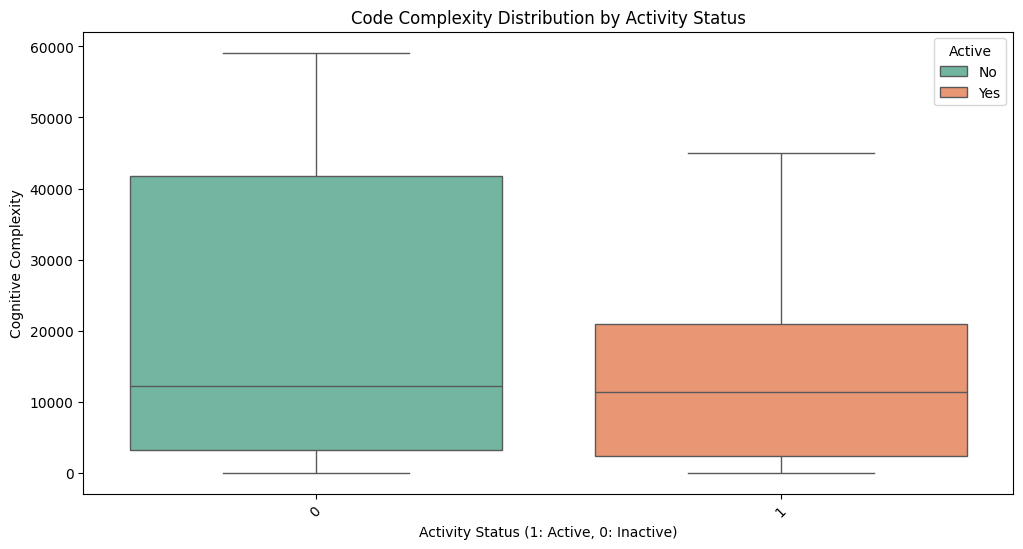

In [27]:
# -----------------------------------------------------------
# Visualization 1: Code Complexity vs Project Activity
# -----------------------------------------------------------
# Motivation: Validate if higher code complexity correlates with inactive status
# Hypothesis: Projects with high cognitive complexity are more likely to become inactive
df = data.copy()
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_active', y='cognitive_complexity', hue='is_active',
            data=df, showfliers=False,
            palette="Set2", width=0.8)
plt.title('Code Complexity Distribution by Activity Status')
plt.xlabel('Activity Status (1: Active, 0: Inactive)')
plt.ylabel('Cognitive Complexity')
plt.legend(title='Active', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()
    

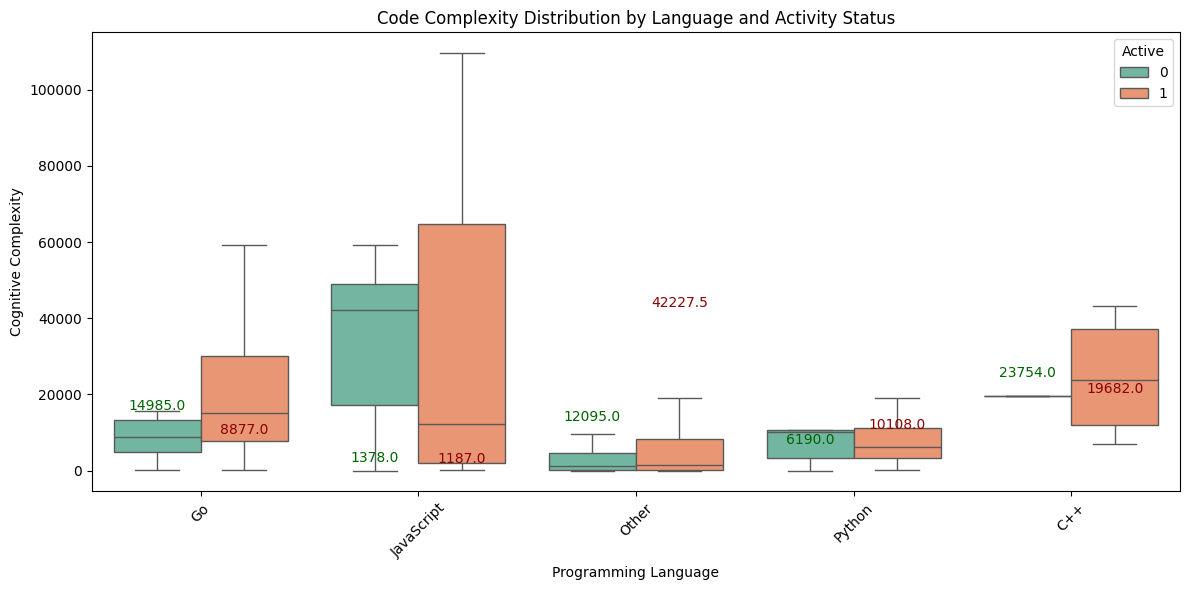

In [28]:
# -----------------------------------------------------------
# Visualization 2: Language-Specific Complexity Thresholds
# -----------------------------------------------------------\
"""
Motivation: Identify language-specific complexity thresholds for sustainability
Hypothesis: Different languages have different acceptable complexity levels
"""
plt.figure(figsize=(12, 6))

# Filter top 5 languages
top_langs = df['language'].value_counts().nlargest(5).index
filtered_df = df[df['language'].isin(top_langs)]

# Boxplot with activity status
sns.boxplot(x='language', y='cognitive_complexity', hue='is_active',
        data=filtered_df, showfliers=False,
        palette="Set2", width=0.8)

plt.title('Code Complexity Distribution by Language and Activity Status')
plt.xlabel('Programming Language')
plt.ylabel('Cognitive Complexity')
plt.legend(title='Active', loc='upper right')
plt.xticks(rotation=45)

# Add median labels
for i, lang in enumerate(top_langs):
        med_active = filtered_df[(filtered_df['language']==lang) & 
                                (filtered_df['is_active']==1)]['cognitive_complexity'].median()
        med_inactive = filtered_df[(filtered_df['language']==lang) & 
                                        (filtered_df['is_active']==0)]['cognitive_complexity'].median()
        plt.text(i-0.2, med_active+2, f'{med_active:.1f}', 
                ha='center', va='bottom', color='darkgreen')
        plt.text(i+0.2, med_inactive+2, f'{med_inactive:.1f}', 
                ha='center', va='bottom', color='darkred')

plt.tight_layout()
plt.show()

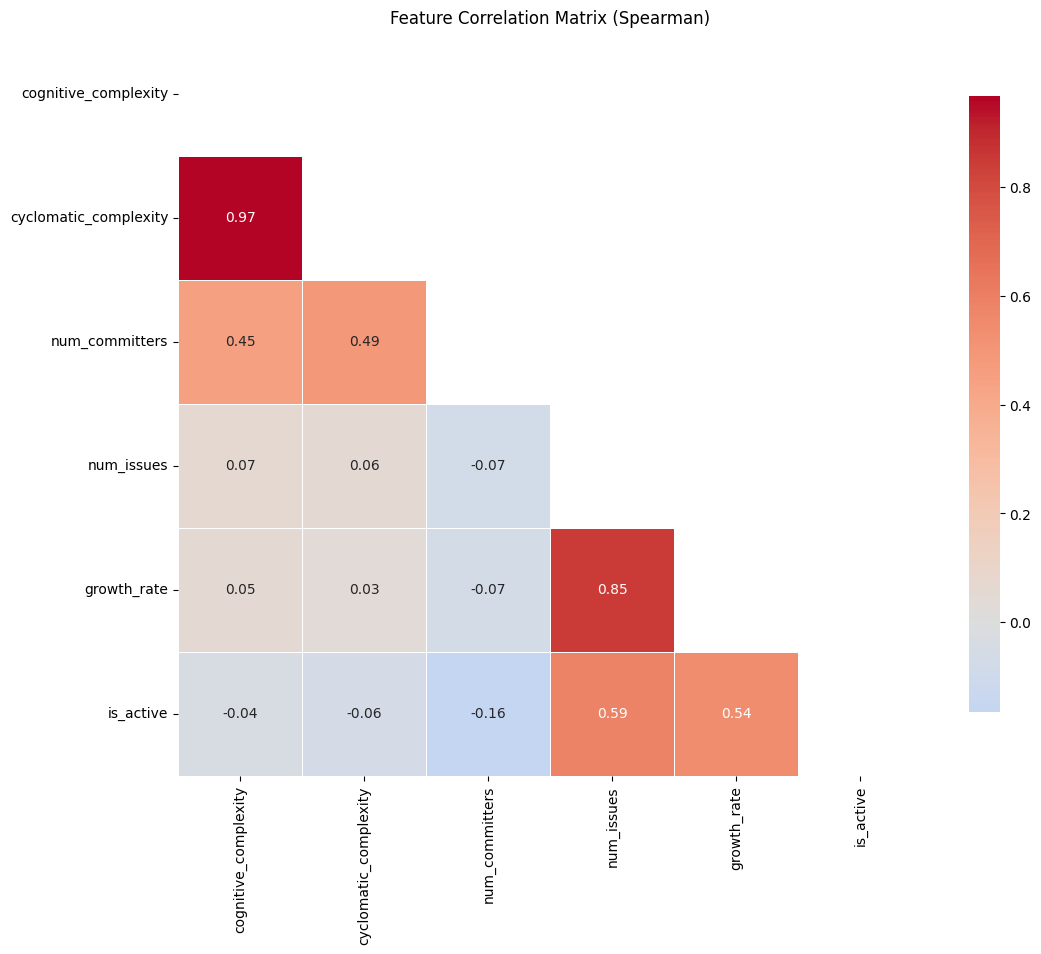

In [29]:
# -----------------------------------------------------------
# Visualization 3: Feature Correlation Matrix
# -----------------------------------------------------------
"""
Motivation: Identify multicollinearity between predictive features
Hypothesis: Some code metrics and community metrics are highly correlated
"""
# Select key features
features = ['cognitive_complexity', 'cyclomatic_complexity', 
            'num_committers', 'num_issues', 'growth_rate',
            'is_active']

plt.figure(figsize=(12, 10))

# Compute correlation matrix
corr = df[features].corr(method='spearman')

# Generate mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
            cmap="coolwarm", center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('Feature Correlation Matrix (Spearman)')
plt.show()

# Model

## Multi-Model Training


In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, f1_score, average_precision_score,
    r2_score, mean_absolute_error
)
import shap
import matplotlib.pyplot as plt

def train_activity_model(X, y):
    """
    Train and evaluate activity prediction models (Binary Classification)
    
    Parameters:
    X (pd.DataFrame): Feature matrix
    y (pd.Series): is_active labels
    
    Returns:
    dict: Model performance metrics
    """
    # Temporal split validation
    tscv = TimeSeriesSplit(n_splits=5)
    
    # Define models with additional ones
    models = {
        'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression())
        ]),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'XGBoost': XGBClassifier(eval_metric='logloss'),
        'LightGBM': LGBMClassifier(),
        'MLP': MLPClassifier(max_iter=300),
        'SVC': SVC(probability=True)
    }
    
    results = {}
    
    for name, model in models.items():
        metrics = {'auc': [], 'f1': [], 'prc': []}
        print('training model:', name)
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model.fit(X_train, y_train)
            probas = model.predict_proba(X_test)[:, 1]
            
            # Calculate metrics
            metrics['auc'].append(roc_auc_score(y_test, probas))
            metrics['f1'].append(f1_score(y_test, (probas > 0.5).astype(int)))
            metrics['prc'].append(average_precision_score(y_test, probas))
            
        results[name] = {
            'AUC-ROC': np.mean(metrics['auc']),
            'F1-Score': np.mean(metrics['f1']),
            'PR-AUC': np.mean(metrics['prc'])
        }
        
        # SHAP analysis for tree-based models only
        if any(keyword in name for keyword in ['Forest', 'XGB', 'LightGBM']):
            explainer = shap.TreeExplainer(model.named_steps['model'] if isinstance(model, Pipeline) else model)
            shap_values = explainer.shap_values(X_test)
            
            plt.figure()
            if isinstance(shap_values, list) and len(shap_values) == 2:  # 二分类情况
                shap_values = shap_values[1]  # 取正类的SHAP值

            shap.summary_plot(
                shap_values, 
                X_test, 
                plot_type="dot",
                max_display=10,
                show=False
            )
            plt.title(f"{name} Feature Impact")
            plt.tight_layout()
            plt.show()
    
    return results



数据准备完成：
- 活跃度预测：7 特征，176 样本

训练活跃度预测模型...
training model: Logistic Regression
training model: Random Forest


<Figure size 640x480 with 0 Axes>

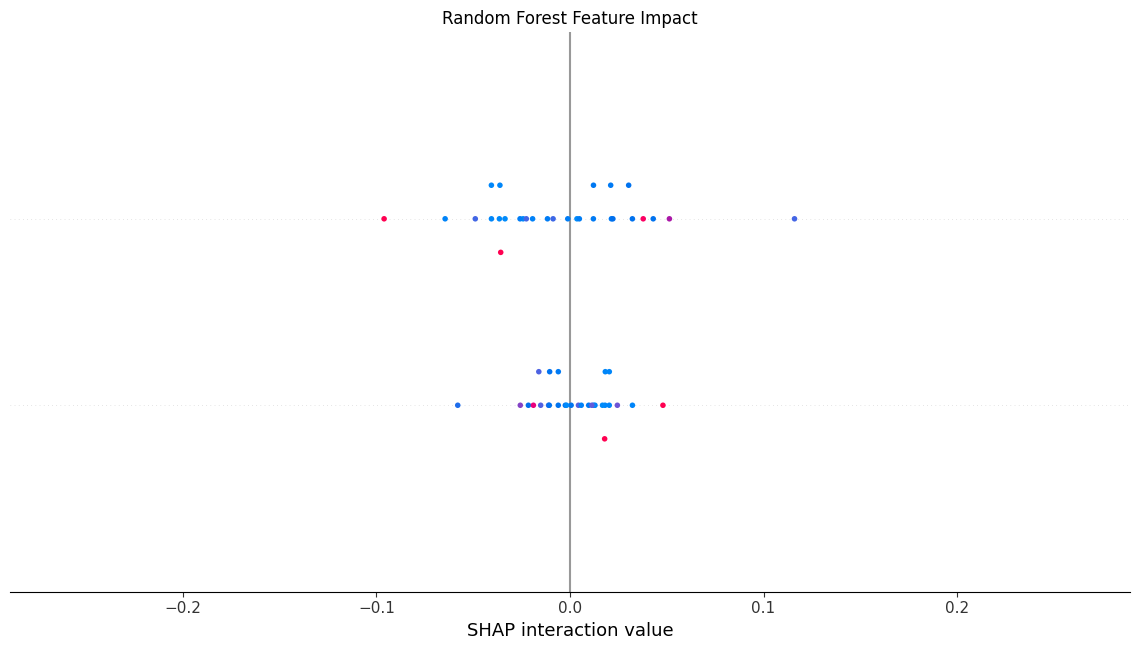

training model: XGBoost


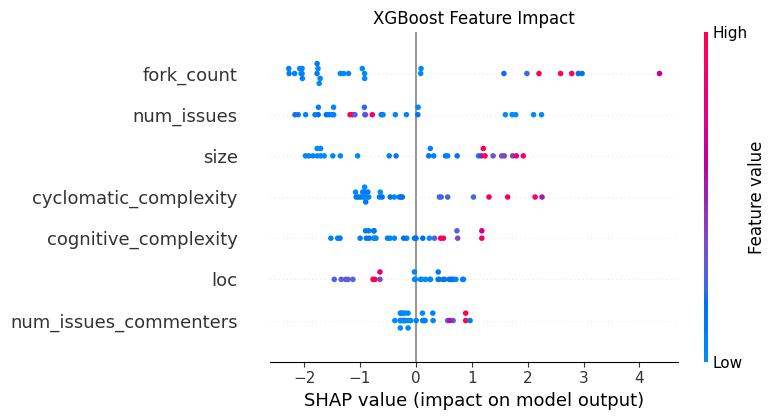

training model: LightGBM
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 12, number of negative: 19
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387097 -> initscore=-0.459532
[LightGBM] [Info] Start training from score -0.459532
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] S

/home/zliwang/anaconda3/envs/complexity/lib/python3.10/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


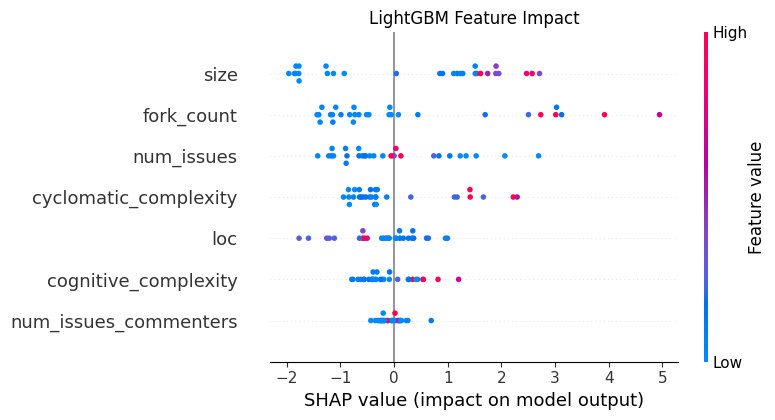

training model: MLP
training model: SVC
{'Logistic Regression': {'AUC-ROC': np.float64(0.803078909394699), 'F1-Score': np.float64(0.5728632478632478), 'PR-AUC': np.float64(0.6652227333781939)}, 'Random Forest': {'AUC-ROC': np.float64(0.9112281362166946), 'F1-Score': np.float64(0.6159027445983968), 'PR-AUC': np.float64(0.8206045368772641)}, 'XGBoost': {'AUC-ROC': np.float64(0.8949043640061947), 'F1-Score': np.float64(0.6882053618895724), 'PR-AUC': np.float64(0.790354136653602)}, 'LightGBM': {'AUC-ROC': np.float64(0.8297530304681334), 'F1-Score': np.float64(0.43645933014354066), 'PR-AUC': np.float64(0.6724489907514986)}, 'MLP': {'AUC-ROC': np.float64(0.5226234063419418), 'F1-Score': np.float64(0.4048042834358624), 'PR-AUC': np.float64(0.3289688170268933)}, 'SVC': {'AUC-ROC': np.float64(0.744404456463953), 'F1-Score': np.float64(0.43838143953233466), 'PR-AUC': np.float64(0.5999500283018261)}}


In [31]:
activity_data = data.copy()
irrelevant_features = ['repo_name', '_id', 'filename', 'html_url', 'language']
time_related_features = ['created_at', 'updated_at', 'pushed_at', 'project_age', 'last_update_interval', 'num_committers',
                       'num_issues_comments', 'num_gov_commits', 'growth_acceleration',  'num_gov_committers', 'star_count', 'num_commits',
                          'num_issues_submitters', 'complexity_medium', 'complexity_high', 'sustainability', 'sustainability_index',
       'complexity_unknown']
X_active = activity_data.drop(columns=irrelevant_features + time_related_features + ['growth_rate', 'is_active'])
y_active = activity_data['sustainability']

print("\n数据准备完成：")
print(f"- 活跃度预测：{X_active.shape[1]} 特征，{len(y_active)} 样本")
print("\n训练活跃度预测模型...")
activity_metrics = train_activity_model(X_active, y_active)
print(activity_metrics)


## LLinear Model

### Linear Model with Complexity & Contributor Size 

Accuracy: 0.7330
ROC-AUC: 0.8251

Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.94      0.83       121
        True       0.68      0.27      0.39        55

    accuracy                           0.73       176
   macro avg       0.71      0.61      0.61       176
weighted avg       0.72      0.73      0.69       176

Optimization terminated successfully.
         Current function value: 0.513486
         Iterations 7

Statistical Summary with P-values:
                           Logit Regression Results                           
Dep. Variable:         sustainability   No. Observations:                  176
Model:                          Logit   Df Residuals:                      170
Method:                           MLE   Df Model:                            5
Date:                Sun, 16 Mar 2025   Pseudo R-squ.:                  0.1732
Time:                        22:22:37   Log-Likelihood:                -90.374
conv

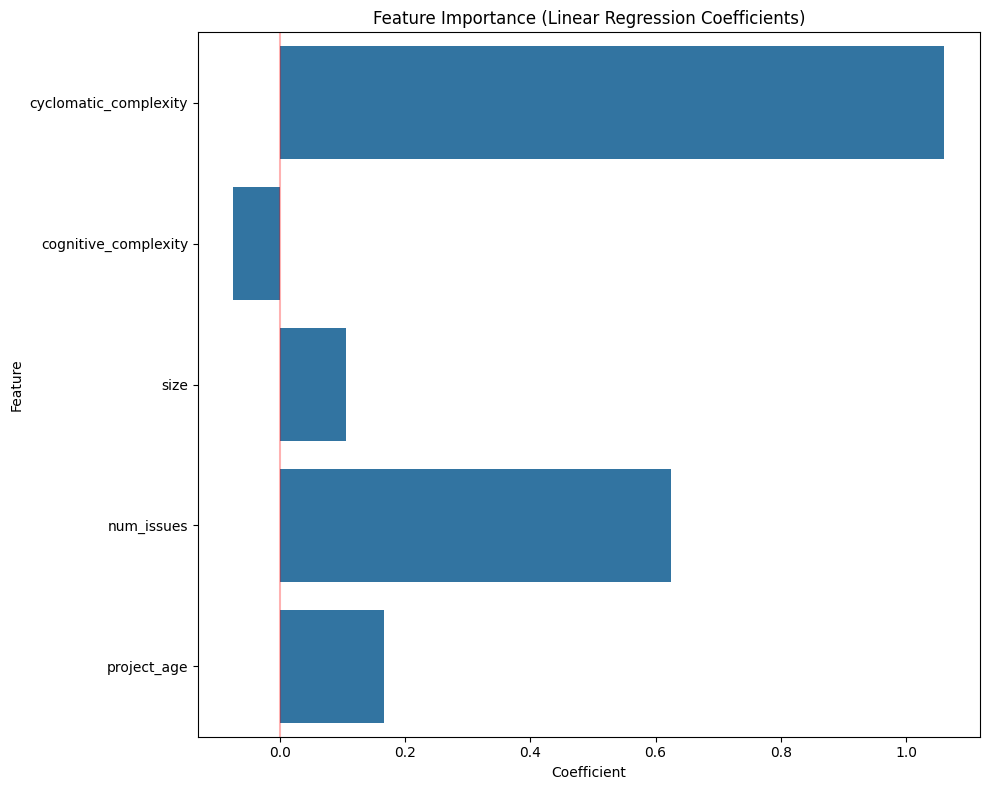

In [32]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np
import statsmodels.api as sm

# Create a data copy for modeling
activity_data = data.copy()

# Define features to exclude
irrelevant_features = ['repo_name', '_id', 'filename', 'html_url', 'language']
time_related_features = ['created_at', 'updated_at', 'pushed_at', 'num_committers', 'loc', 'sustainability','sustainability_index',  
                       'num_issues_commenters', 'num_issues_comments', 'num_gov_commits', 'growth_acceleration', 'num_gov_committers',   'num_commits', 'star_count', 'fork_count', #'size',
                       'num_issues_submitters', 'complexity_medium', 'complexity_high', 'last_update_interval', # 'num_issues',
                'complexity_unknown']

# Prepare feature matrix and target
X_active = activity_data.drop(columns=irrelevant_features + time_related_features + ['growth_rate', 'is_active'])
y_active = activity_data['sustainability']

# Create a pipeline with scaling and logistic regression (more appropriate for binary classification)
pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('model', LogisticRegression(max_iter=1000))
])

# Fit the model
pipeline.fit(X_active, y_active)

# Get predictions
y_pred = pipeline.predict(X_active)
y_prob = pipeline.predict_proba(X_active)[:, 1]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_active, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_active, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_active, y_pred))

# Access the model from the pipeline
model = pipeline.named_steps['model']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_active)
X_sm = sm.add_constant(X_scaled)

# Assign column names to X_sm
X_sm = pd.DataFrame(X_sm, columns=['const'] + list(X_active.columns), index=X_active.index) # Keep the index
sm_model = sm.Logit(y_active, X_sm).fit()

# Print the summary which includes p-values
print("\nStatistical Summary with P-values:")
print(sm_model.summary())

feature_names = X_active.columns

# Check if model.coef_ is 1D or 2D
if len(model.coef_.shape) == 1:
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_
    }).sort_values(by='Coefficient', ascending=False)
else:
    # If it's 2D, take the first row (assuming you want the coefficients for the first target)
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0]  # Or choose a different row if needed
    }) # .sort_values(by='Coefficient', ascending=False)


# Display model information
print(f"Intercept: {model.intercept_}")
print("\nModel Coefficients (sorted by importance):")
print(coefficients)
# Visualize coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
# 保存为pdf
plt.savefig('Linear_Model_with_Complexity_Contributor_Size.pdf', format='pdf')


### Linear Model with Size 

Accuracy: 0.7386
ROC-AUC: 0.7814

Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.95      0.83       121
        True       0.71      0.27      0.39        55

    accuracy                           0.74       176
   macro avg       0.73      0.61      0.61       176
weighted avg       0.73      0.74      0.70       176

Optimization terminated successfully.
         Current function value: 0.526336
         Iterations 7

Statistical Summary with P-values:
                           Logit Regression Results                           
Dep. Variable:         sustainability   No. Observations:                  176
Model:                          Logit   Df Residuals:                      172
Method:                           MLE   Df Model:                            3
Date:                Sun, 16 Mar 2025   Pseudo R-squ.:                  0.1526
Time:                        22:22:38   Log-Likelihood:                -92.635
conv

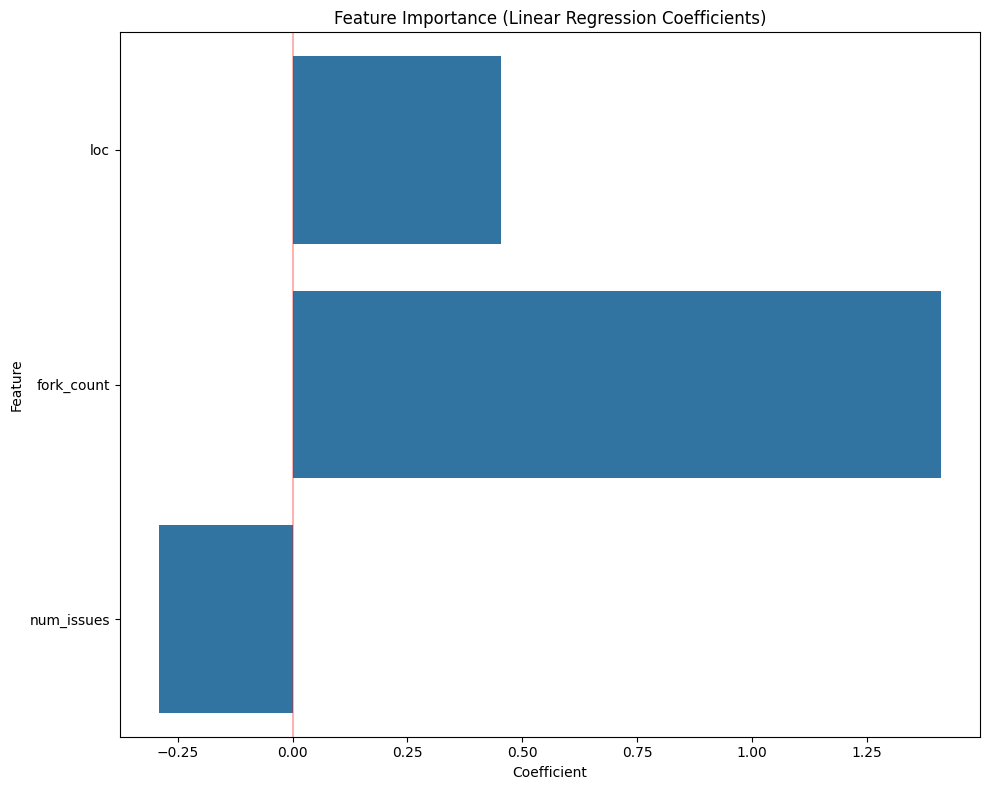

In [33]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np
import statsmodels.api as sm

# Create a data copy for modeling
activity_data = data.copy()

# Define features to exclude
irrelevant_features = ['repo_name', '_id', 'filename', 'html_url', 'language']
time_related_features = ['created_at', 'updated_at', 'pushed_at', 'num_committers',  'cognitive_complexity', 'cyclomatic_complexity', 'sustainability', 'sustainability_index',
                       'num_issues_commenters', 'num_issues_comments', 'num_gov_commits', 'growth_acceleration', 'num_gov_committers','star_count','project_age', 'size', #'loc',
                       'num_issues_submitters', 'complexity_medium', 'complexity_high', 'last_update_interval',   'num_commits', # 'num_issues',  'fork_count',
                'complexity_unknown']
X_active = activity_data.drop(columns=irrelevant_features + time_related_features + ['growth_rate', 'is_active'])
y_active = activity_data['sustainability']

# Create a pipeline with scaling and logistic regression (more appropriate for binary classification)
pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('model', LogisticRegression(max_iter=1000))
])

# Fit the model
pipeline.fit(X_active, y_active)

# Get predictions
y_pred = pipeline.predict(X_active)
y_prob = pipeline.predict_proba(X_active)[:, 1]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_active, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_active, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_active, y_pred))

# Access the model from the pipeline
model = pipeline.named_steps['model']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_active)
X_sm = sm.add_constant(X_scaled)

# Assign column names to X_sm
X_sm = pd.DataFrame(X_sm, columns=['const'] + list(X_active.columns), index=X_active.index) # Keep the index
sm_model = sm.Logit(y_active, X_sm).fit()

# Print the summary which includes p-values
print("\nStatistical Summary with P-values:")
print(sm_model.summary())

feature_names = X_active.columns

# Check if model.coef_ is 1D or 2D
if len(model.coef_.shape) == 1:
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_
    }).sort_values(by='Coefficient', ascending=False)
else:
    # If it's 2D, take the first row (assuming you want the coefficients for the first target)
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0]  # Or choose a different row if needed
    }) # .sort_values(by='Coefficient', ascending=False)


# Display model information
print(f"Intercept: {model.intercept_}")
print("\nModel Coefficients (sorted by importance):")
print(coefficients)
# Visualize coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
# 保存为pdf
plt.savefig('Linear_Model_with_Size.pdf', format='pdf')

### Linear Model with Complexity Features

Accuracy: 0.7386
ROC-AUC: 0.7663

Classification Report:
              precision    recall  f1-score   support

       False       0.74      0.96      0.83       121
        True       0.74      0.25      0.38        55

    accuracy                           0.74       176
   macro avg       0.74      0.61      0.61       176
weighted avg       0.74      0.74      0.69       176

Optimization terminated successfully.
         Current function value: 0.542994
         Iterations 6

Statistical Summary with P-values:
                           Logit Regression Results                           
Dep. Variable:         sustainability   No. Observations:                  176
Model:                          Logit   Df Residuals:                      173
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Mar 2025   Pseudo R-squ.:                  0.1257
Time:                        22:22:38   Log-Likelihood:                -95.567
conv

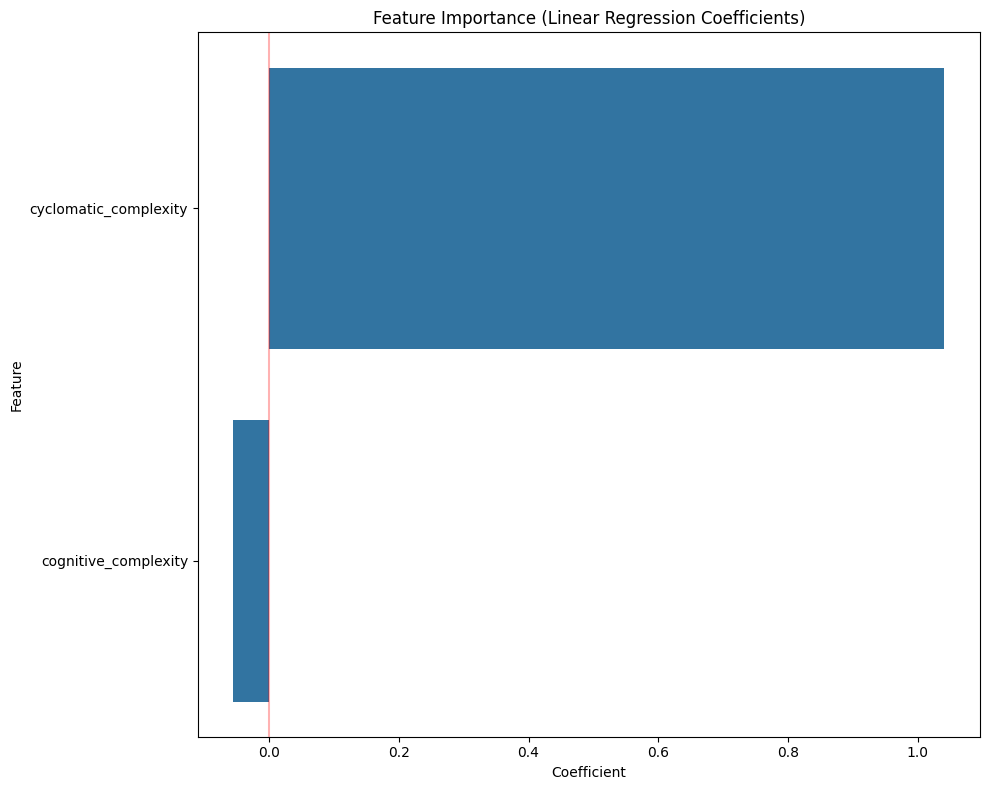

In [34]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np
import statsmodels.api as sm

# Create a data copy for modeling
activity_data = data.copy()

# Define features to exclude
irrelevant_features = ['repo_name', '_id', 'filename', 'html_url', 'language']
time_related_features = ['created_at', 'updated_at', 'pushed_at', 'num_committers', 'loc',# 'cognitive_complexity', 'cyclomatic_complexity',
                       'num_issues_commenters', 'num_issues_comments', 'num_gov_commits', 'growth_acceleration', 'num_gov_committers', 'size', 'fork_count','star_count','project_age','size',
                       'num_issues_submitters', 'complexity_medium', 'complexity_high', 'last_update_interval', 'num_issues', 'num_commits', 'sustainability_index', 'sustainability',
                'complexity_unknown']
X_active = activity_data.drop(columns=irrelevant_features + time_related_features + ['growth_rate', 'is_active'])
y_active = activity_data['sustainability']

# Create a pipeline with scaling and logistic regression (more appropriate for binary classification)
pipeline = Pipeline([
          ('scaler', StandardScaler()),
          ('model', LogisticRegression(max_iter=1000))
])

# Fit the model
pipeline.fit(X_active, y_active)

# Get predictions
y_pred = pipeline.predict(X_active)
y_prob = pipeline.predict_proba(X_active)[:, 1]

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_active, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_active, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_active, y_pred))

# Access the model from the pipeline
model = pipeline.named_steps['model']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_active)
X_sm = sm.add_constant(X_scaled)

# Assign column names to X_sm
X_sm = pd.DataFrame(X_sm, columns=['const'] + list(X_active.columns), index=X_active.index) # Keep the index
sm_model = sm.Logit(y_active, X_sm).fit()

# Print the summary which includes p-values
print("\nStatistical Summary with P-values:")
print(sm_model.summary())

feature_names = X_active.columns

# Check if model.coef_ is 1D or 2D
if len(model.coef_.shape) == 1:
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_
    }).sort_values(by='Coefficient', ascending=False)
else:
    # If it's 2D, take the first row (assuming you want the coefficients for the first target)
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0]  # Or choose a different row if needed
    }) # .sort_values(by='Coefficient', ascending=False)


# Display model information
print(f"Intercept: {model.intercept_}")
print("\nModel Coefficients (sorted by importance):")
print(coefficients)
# Visualize coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
# 保存为pdf
plt.savefig('Linear_Model_with_Complexity.pdf', format='pdf')